In [33]:
# from utils_fs_v2 import DataGenerator_res2
from jax import grad, vmap, jit, nn
# import jax.numpy as np
# import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import jax.numpy as np
import jax.lax as lax
import jax.tree_util as tu
import matplotlib.pyplot as plt
import math


In [34]:
dom_lens = np.array([1.,1.])
delta = 1.9

def weight_condition(condition,u,mu,sigma):
    w = lax.cond(condition, lambda u: (1 + np.cos(math.pi*(u-mu)/sigma))**2, lambda _: 0., u)
    return w

# Changed this function
# def w_jl(j, l, t, x):        
#     L = np.sqrt(l)
#     # L = np.sqrt(l).astype(int)
#     J = np.array([j % L, j // L])
#     mu = dom_lens*J/(L-1)
#     t_mu = mu[0]
#     x_mu = mu[1]
#     sigma = dom_lens*(delta/2.0)/(L-1)
#     t_sigma = sigma[0]
#     x_sigma = sigma[1]
#     # conditions = ((u < (mu + sigma)) & (u > (mu - sigma))).all()
#     t_conditions = ((t < (t_mu + t_sigma)) & (t > (t_mu - t_sigma))).all()
#     x_conditions = ((x < (x_mu + x_sigma)) & (x > (x_mu - x_sigma))).all()
#     conditions = x_conditions & t_conditions
#     conditions = conditions.reshape(-1)
#     t_w = vmap(weight_condition,(0,0,None,None))(conditions,t,t_mu,t_sigma)
#     x_w = vmap(weight_condition,(0,0,None,None))(conditions,x,x_mu,x_sigma)
#     weight = t_w*x_w
#     return weight

# Changed this function
def w_jl(j, l, t, x):        
    L = np.sqrt(l)
    J = np.array([j % L, j // L])
    mu = dom_lens*J/(L-1)
    sigma = dom_lens*(delta/2.0)/(L-1)
    t_conditions = ((t < (mu[0] + sigma[0])) & (t > (mu[0] - sigma[0]))).all()
    x_conditions = ((x < (mu[1] + sigma[1])) & (x > (mu[1] - sigma[1]))).all()
    conditions = x_conditions & t_conditions
    conditions = conditions.reshape(-1)
    t_w = vmap(weight_condition,(0,0,None,None))(conditions,t,mu[0],sigma[0])
    x_w = vmap(weight_condition,(0,0,None,None))(conditions,x,mu[1],sigma[1])
    weight = t_w*x_w
    return weight

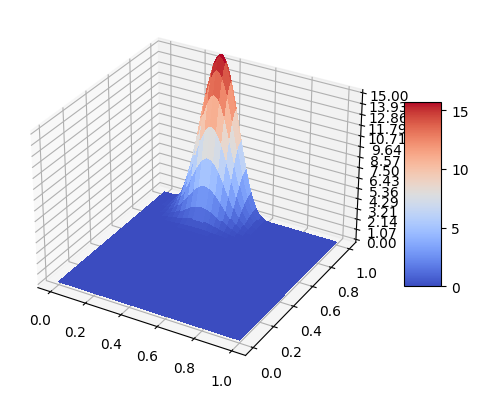

In [35]:
# import matplotlib.pyplot as plt

# import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.linspace(0, 1, 101)
lx = len(X)
T = np.linspace(0, 1, 101)
lt = len(T)
T, X = np.meshgrid(T, X)
TX = np.array([T,X]).reshape(2,lx*lt)
TX = TX.T
t = TX[:,0].reshape(-1,1)
x = TX[:,1].reshape(-1,1)
# print(XY.shape)

Z = vmap(w_jl,(None,None,0,0))(7,16,t,x)
# R = np.sqrt(X**2 + Y**2)
# Z = np.sin(R)
Z = Z.reshape((lt,lx))
# print(Z)

# Plot the surface.
surf = ax.plot_surface(X, T, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# surf = ax.contourf(X, T, Z, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)
# surf = ax.contourf(X, T, Z, cmap=cm.coolwarm)

# Customize the z axis.
ax.set_zlim(0, 15)
ax.zaxis.set_major_locator(LinearLocator(15))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which mas values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [ ]:
plt

In [14]:
a = 16
d = np.sqrt(a).astype(int)
b = 7
print(b // d)
print(b % d)

1
3


In [15]:
v1 = np.array([2,3])
v2 = np.array([5,3])
v1*v2

array([10,  9])

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, random, pmap

def neural_network(params, x):
    # Implement your neural network architecture
    # This can be any function that applies a series of transformations to input `x`
    # using the parameters `params`.
    # For example:
    return jnp.dot(x, params)

def loss_fn(params, x, y_true):
    # Implement your loss function
    y_pred = neural_network(params, x)
    return jnp.mean((y_pred - y_true)**2)

def init_params(rng, input_shape):
    return random.normal(rng, (input_shape,))  # Adjust the shape based on your architecture.

def pmap_training_step(params, x_batch, y_batch):
    # Run the training step on each device in parallel.
    grads = grad(loss_fn)(params, x_batch, y_batch)
    return [param - learning_rate * grad for param, grad in zip(params, grads)]

def parallel_train(neural_network, init_params, data, num_epochs, batch_size, learning_rate):
    rng = random.PRNGKey(0)
    num_devices = jax.device_count()

    # Initialize the model parameters on each device
    params = [init_params(random.split(rng, num_devices), input_shape) for input_shape in data['input_shapes']]

    for epoch in range(num_epochs):
        # Split the data into batches for each device
        data_batches = [(device_data['x'], device_data['y']) for device_data in data['device_data']]
        for x_batch, y_batch in zip(*data_batches):
            # Run the training step in parallel
            params = pmapped_training_step(params, x_batch, y_batch)

    return params

# Prepare your data (you might need to organize it based on the number of devices)
data = {
    'device_data': [...],  # A list of (x, y) data for each device
    'input_shapes': [...],  # List of input shapes for each device's data
}

num_epochs = 10
batch_size = 32
learning_rate = 0.001

# Parallelize the training function
pmapped_training_step = pmap(pmap_training_step)

# Call the training function
trained_params = parallel_train(neural_network, init_params, data, num_epochs, batch_size, learning_rate)


# Trying to Train Neural Networks with Overlap

In [38]:
def init_mlp_params(layer_widths):
  params = []
  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(
        dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
             biases=np.ones(shape=(n_out,))
            )
    )
  return params

In [39]:
# tree_map(lambda x: x.shape, params)

In [40]:
def forward(params, x):
  *hidden, last = params
  for layer in hidden:
    x = nn.relu(x @ layer['weights'] + layer['biases'])
  return x @ last['weights'] + last['biases']

def loss_fn(nn, x, y):
  return jnp.mean((forward(nn.params, x) - y) ** 2)

LEARNING_RATE = 0.0001

@jit
def update(nn, x, y):
  grad_loss_fn = grad(loss_fn)
  grads = tu.tree_map(grad_loss_fn,nn, x, y)
  # Note that `grads` is a pytree with the same structure as `params`.
  # `jax.grad` is one of the many JAX functions that has
  # built-in support for pytrees.

  # This is handy, because we can apply the SGD update using tree utils:
  return tu.tree_map(
      lambda p, g: p - LEARNING_RATE * g, nn, grads
  )

In [41]:
class ParameterContainer:
    def __init__(self):
        self.params = init_mlp_params([1, 128, 128, 1])

In [42]:
# params1 = init_mlp_params([1, 128, 128, 1])
# params2 = init_mlp_params([1, 128, 128, 1])
nn1 = ParameterContainer()
nn2 = ParameterContainer()
nn = [nn1, nn2]
xs1 = 0.5*np.random.uniform(size=(70, 1))
ys1 = xs1 ** 2
xs2 = 0.5*np.random.uniform(size=(60, 1)) + 0.5
ys2 = xs2 ** 2
xs = [xs1,xs2]
ys = [ys1,ys2]

# print(tu.tree_structure(nn))
# print(tu.tree_structure(xs))
# print(tu.tree_structure(ys))

# tu.treedef_is_leaf(params)
# type(params)

In [43]:
for _ in range(10000):
  params1 = update(nn, xs, ys)

# plt.scatter(xs, ys)
# plt.scatter(xs, forward(params1, xs), label='Model prediction')
plt.legend()

TypeError: Cannot interpret value of type <class '__main__.ParameterContainer'> as an abstract array; it does not have a dtype attribute

In [1]:
temp1 = [-1,3]
temp2 = [2,3,4]
temp3 = [0,6]
temp = [temp1,temp2,temp3]

3

In [11]:
# domain_bounds = jnp.array([0.,1.])
# single_domains = jnp.array([[0.,0.4],[0.6,1.]])
# double_domains = jnp.array([[0.4,0.6]])

domain_bounds = jnp.array([0.,2.])
single_domains = jnp.array([[0.,0.4],[0.6,1.],[1.333,2.0]])
double_domains = jnp.array([[0.4,0.6],[1.,1.333]])
D = DataGenerator_res2(domain_bounds,single_domains,double_domains,10)

In [12]:
# D.single_domain_point_dict

In [13]:
def show_example(structured):
  flat, tree = tree_flatten(structured)
  unflattened = tree_unflatten(tree, flat)
  print(f"{structured=}\n  {flat=}\n  {tree=}\n  {unflattened=}")

In [14]:
show_example(D.single_domain_point_dict)

structured=[{'res_pts': Array([[0.34768867]], dtype=float32), 'uni_pts': Array([[0.06492133]], dtype=float32)}, {'res_pts': Array([[0.84995735]], dtype=float32), 'uni_pts': Array([[0.63279486]], dtype=float32)}, {'res_pts': Array([[1.8789763]], dtype=float32), 'uni_pts': Array([[1.9840243],
       [1.5907514]], dtype=float32)}]
  flat=[Array([[0.34768867]], dtype=float32), Array([[0.06492133]], dtype=float32), Array([[0.84995735]], dtype=float32), Array([[0.63279486]], dtype=float32), Array([[1.8789763]], dtype=float32), Array([[1.9840243],
       [1.5907514]], dtype=float32)]
  tree=PyTreeDef([{'res_pts': *, 'uni_pts': *}, {'res_pts': *, 'uni_pts': *}, {'res_pts': *, 'uni_pts': *}])
  unflattened=[{'res_pts': Array([[0.34768867]], dtype=float32), 'uni_pts': Array([[0.06492133]], dtype=float32)}, {'res_pts': Array([[0.84995735]], dtype=float32), 'uni_pts': Array([[0.63279486]], dtype=float32)}, {'res_pts': Array([[1.8789763]], dtype=float32), 'uni_pts': Array([[1.9840243],
       [1.59